# CAVA Stock Price Prediction
### kaltonphxn
Predicting the stock price of Cava using its stock data pulled from Yahoo Finance using SARIMA and Linear Regression

## Pre-Processing

In [25]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
#Read in data set
data = pd.read_csv(r'D:\Projects\CAVA_closing_prices.csv')
data.head()

,Price,Close
0,Ticker,CAVA
1,Date,NaN
2,2023-06-16,38.150001525878906
3,2023-06-20,38.43000030517578
4,2023-06-21,38.34000015258789


In [4]:
# Clean formatting
data_cleaned = data.iloc[2:].reset_index(drop=True)
data_cleaned.columns = ["Date", "Close"]
data_cleaned["Date"] = pd.to_datetime(data_cleaned["Date"])
data_cleaned["Close"] = pd.to_numeric(data_cleaned["Close"], errors="coerce")
print(data_cleaned.head())
data_cleaned.to_csv("CAVA_cleaned.csv", index=False)

        Date      Close
0 2023-06-16  38.150002
1 2023-06-20  38.430000
2 2023-06-21  38.340000
3 2023-06-22  39.160000
4 2023-06-23  40.150002


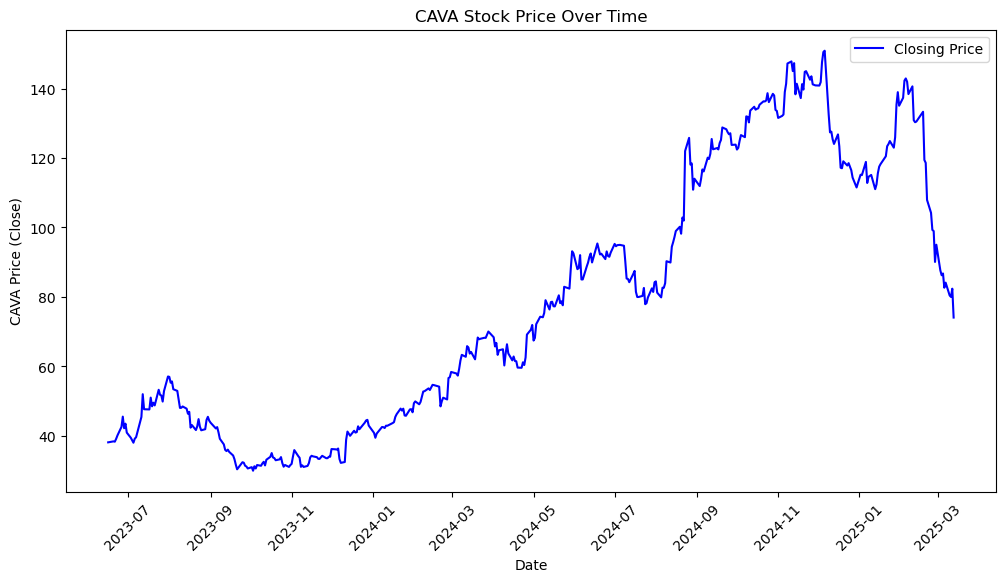

In [5]:
# Plot closing price over time
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned["Date"], data_cleaned["Close"], linestyle='-', color='b', label="Closing Price")
plt.xlabel("Date")
plt.ylabel("CAVA Price (Close)")
plt.title("CAVA Stock Price Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [6]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Ensure the data is sorted by date (important for time-series)
data_cleaned = data_cleaned.sort_values(by="Date").reset_index(drop=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute split indices
total_samples = len(data_cleaned)
train_end = int(total_samples * train_ratio)
val_end = train_end + int(total_samples * val_ratio)

# Perform the split
train_data = data_cleaned.iloc[:train_end]  # Training set
val_data = data_cleaned.iloc[train_end:val_end]  # Validation set
test_data = data_cleaned.iloc[val_end:]  # Test set

# Display the split sizes
print(f"Train set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Train set: 305 samples
Validation set: 65 samples
Test set: 66 samples


## SARIMA

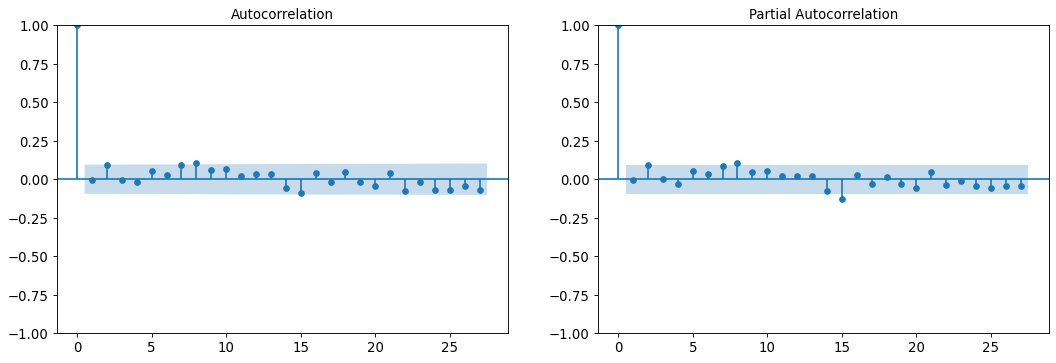

In [ ]:

#Plot PACF and ACF to determine SARIMA parameters
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
data_cleaned['Close_Diff'] = data_cleaned['Close'].diff()

# Drop the first row with NaN after differencing
data_cleaned.dropna(subset=['Close_Diff'], inplace=True)


#Ensure the data is sorted by date
data_cleaned = data_cleaned.sort_values(by="Date").reset_index(drop=True)



#Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data_cleaned['Close_Diff'], ax=ax1)
plot_pacf(data_cleaned['Close_Diff'], method='ywm', ax=ax2)
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()



In [7]:
# Define SARIMA model with estimated parameters
sarima_model = SARIMAX(train_data["Close"], 
order=(2, 1, 1),  # (p, d, q)
seasonal_order=(1, 1, 1, 30))  # (P, D, Q, S)

In [8]:
# Fit the model
sarima_fit = sarima_model.fit()

In [9]:
# Forecast on validation set
val_forecast = sarima_fit.get_forecast(steps=len(val_data))
val_predicted_mean = val_forecast.predicted_mean

# Forecast on test set (evaluation)
test_forecast = sarima_fit.get_forecast(steps=len(test_data))
test_predicted_mean = test_forecast.predicted_mean

# Compute evaluation metrics for validation set
val_mae = mean_absolute_error(val_data["Close"], val_predicted_mean)
val_mse = mean_squared_error(val_data["Close"], val_predicted_mean)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(val_data["Close"], val_predicted_mean)

# Compute evaluation metrics for test set
test_mae = mean_absolute_error(test_data["Close"], test_predicted_mean)
test_mse = mean_squared_error(test_data["Close"], test_predicted_mean)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_data["Close"], test_predicted_mean)

# Print evaluation metrics
print(f"Validation MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R2: {val_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")


Validation MAE: 5.93, MSE: 46.95, RMSE: 6.85, R2: 0.37
Test MAE: 17.72, MSE: 676.89, RMSE: 26.02, R2: -1.05


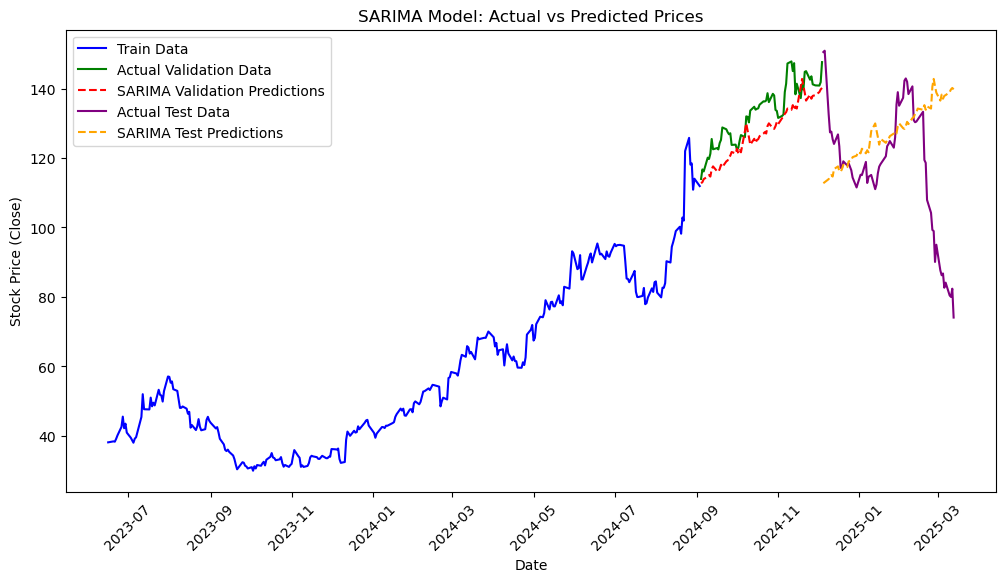

In [10]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data["Date"], train_data["Close"], label="Train Data", color="blue")
plt.plot(val_data["Date"], val_data["Close"], label="Actual Validation Data", color="green")
plt.plot(val_data["Date"], val_predicted_mean, label="SARIMA Validation Predictions", color="red", linestyle="dashed")
plt.plot(test_data["Date"], test_data["Close"], label="Actual Test Data", color="purple")
plt.plot(test_data["Date"], test_predicted_mean, label="SARIMA Test Predictions", color="orange", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price (Close)")
plt.title("SARIMA Model: Actual vs Predicted Prices")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Linear Regression

In [11]:
# Create "Time_Index" before splitting
data_cleaned["Time_Index"] = np.arange(len(data_cleaned))

# Now split the dataset (reusing SARIMA's split)
train_data = data_cleaned.iloc[:train_end]
val_data = data_cleaned.iloc[train_end:val_end]
test_data = data_cleaned.iloc[val_end:]

# Ensure "Time_Index" is present
print(train_data.columns)  # Should include "Time_Index"
print(val_data.columns)  # Should include "Time_Index"
print(test_data.columns)  # Should include "Time_Index"

# Define features and target variable
X_train, y_train = train_data[["Time_Index"]], train_data["Close"]
X_val, y_val = val_data[["Time_Index"]], val_data["Close"]
X_test, y_test = test_data[["Time_Index"]], test_data["Close"]

# Add constant term for OLS regression
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
X_test = sm.add_constant(X_test)

Index(['Date', 'Close', 'Time_Index'], dtype='object')
Index(['Date', 'Close', 'Time_Index'], dtype='object')
Index(['Date', 'Close', 'Time_Index'], dtype='object')


In [12]:
# Fit OLS model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     781.2
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           7.12e-86
Time:                        10:49:38   Log-Likelihood:                -1186.6
No. Observations:                 305   AIC:                             2377.
Df Residuals:                     303   BIC:                             2385.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0674      1.357     18.471      0.0

In [13]:
# Make predictions
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

In [14]:
# Compute evaluation metrics
val_mae = mean_absolute_error(y_val, val_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

# Print evaluation metrics
print(f"Validation MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R2: {val_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

Validation MAE: 35.05, MSE: 1254.72, RMSE: 35.42, R2: -15.92
Test MAE: 17.92, MSE: 455.25, RMSE: 21.34, R2: -0.38


In [21]:
data_cleaned = data_cleaned.sort_values(by='Date')
data_cleaned['Lag_1'] = data_cleaned['Close'].shift(1)
data_cleaned['Lag_2'] = data_cleaned['Close'].shift(2)
data_cleaned = data_cleaned.dropna()
X = data_cleaned[['Lag_1', 'Lag_2']]  
y = data_cleaned['Close']
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
mae_scores, rmse_scores, r2_scores = [], [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Print average scores
print("\nAverage Cross-Validation Scores:")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.2f}")
print(f"Mean R²: {np.mean(r2_scores):.2f}")

Fold MAE: 0.97, RMSE: 1.37, R²: 0.93
Fold MAE: 1.72, RMSE: 2.27, R²: 0.91
Fold MAE: 1.99, RMSE: 2.67, R²: 0.83
Fold MAE: 2.39, RMSE: 3.74, R²: 0.89
Fold MAE: 3.25, RMSE: 4.74, R²: 0.94

Average Cross-Validation Scores:
Mean MAE: 2.06
Mean RMSE: 2.96
Mean R²: 0.90


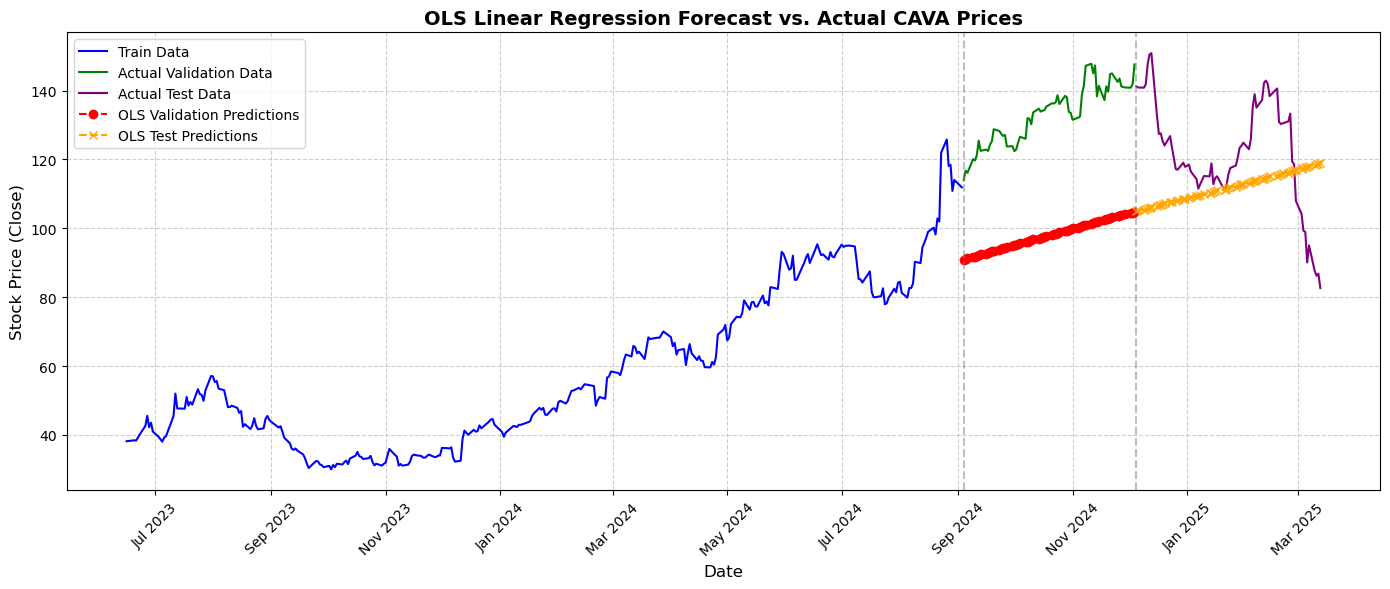

In [26]:
# Align validation and test data to predictions
val_data_aligned = val_data.iloc[:len(val_predictions)]
y_val_aligned = y_val[:len(val_predictions)]

test_data_aligned = test_data.iloc[:len(test_predictions)]
y_test_aligned = y_test[:len(test_predictions)]

# Create the comparison plot
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(train_data["Date"], train_data["Close"], label="Train Data", color="blue")
plt.plot(val_data_aligned["Date"], y_val_aligned, label="Actual Validation Data", color="green")
plt.plot(test_data_aligned["Date"], y_test_aligned, label="Actual Test Data", color="purple")

# Plot predictions
plt.plot(val_data_aligned["Date"], val_predictions, label="OLS Validation Predictions",
         color="red", linestyle="--", marker='o')
plt.plot(test_data_aligned["Date"], test_predictions, label="OLS Test Predictions",
         color="orange", linestyle="--", marker='x')

# Add vertical lines to show data splits
plt.axvline(x=val_data["Date"].iloc[0], color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=test_data["Date"].iloc[0], color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (Close)", fontsize=12)
plt.title("OLS Linear Regression Forecast vs. Actual CAVA Prices", fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion
In this project, I explored two approaches to forecast CAVA stock prices: The study used two prediction methodologies: a SARIMA time series model and an OLS Linear Regression model. The models underwent training and evaluation using training, validation, and test datasets to measure their predictive performance and generalization ability.

The Linear Regression model demonstrated good performance on the validation data through accurate predictions with moderate prediction errors. The model showed severe underperformance during the test phase with high MAE and negative R² score results which signaled its inability to generalize well. The application of time series cross-validation revealed consistent model performance during training folds with MAE of 2.06 and RMSE of 2.96 but exposed its inability to handle structural changes in the unseen test data. The model maintained stable performance within its sample but could not adapt to changes in market dynamics.

The SARIMA model showed consistent and stable performance during the validation stage. The model demonstrated strong ability to track the overall upward direction and efficiently moved from training to validation phases. The model's predictions during the test period appeared excessively smoothed which led to an inability to capture significant price movements and sudden directional changes. Although SARIMA successfully models underlying trends and seasonal patterns it fails to adapt properly during abrupt market volatility.

SARIMA exhibited reliable trend-following capabilities whereas the Linear Regression model demonstrated adaptability but struggled to maintain robustness in volatile market conditions. The strengths and limitations of both models were clear for me. As I continue my journey through my data science graduate program, I intend to investigate advanced methods including LSTM neural networks, XGBoost, and hybrid models which can achieve better balance between trend learning and price shock responsiveness once those topics are touched upon in my course work. 